In [23]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = "/Users/himabindhudoddi/Documents/Desktop/Courses/PDS/consolidated_genome_data.csv"
genome_data = pd.read_csv(file_path)

# Step 1: Identify missing values
# Summarize missing values
missing_summary = genome_data.isnull().sum()
print("Missing Values Summary:\n", missing_summary)

# Step 2: Handle critical missing values
# Drop rows with missing 'gcPercent' or 'Gene' values
cleaned_data = genome_data.dropna(subset=['gcPercent', 'Gene'])

# Step 3: Impute non-critical missing values
# For numerical columns, fill missing values with the median
numerical_columns = cleaned_data.select_dtypes(include=[np.number]).columns
for col in numerical_columns:
    cleaned_data[col].fillna(cleaned_data[col].median(), inplace=True)

# For categorical columns, fill missing values with "Unknown"
categorical_columns = cleaned_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    cleaned_data[col].fillna("Unknown", inplace=True)

# Step 4: Standardize column names (optional, for easier referencing)
cleaned_data.columns = cleaned_data.columns.str.strip().str.lower().str.replace(' ', '_')

# Step 5: Remove duplicates
# Check for duplicates in 'Gene' or across the entire dataset
duplicates = cleaned_data.duplicated(subset='gene', keep='first').sum()
print(f"Number of duplicate rows in 'Gene': {duplicates}")
cleaned_data = cleaned_data.drop_duplicates(subset='gene', keep='first')

# Step 6: Validate data ranges and fix inconsistencies
# Ensure GC content is within 0–100
invalid_gc_values = cleaned_data[(cleaned_data['gcpercent'] < 0) | (cleaned_data['gcpercent'] > 100)]
print(f"Rows with invalid GC content: {len(invalid_gc_values)}")
cleaned_data = cleaned_data[(cleaned_data['gcpercent'] >= 0) & (cleaned_data['gcpercent'] <= 100)]



Missing Values Summary:
 assemblyAccession               19339
assemblyUnit                    19339
assignedMoleculeLocationType    19339
chrName                         19339
gcCount                         25634
gcPercent                       25634
genbankAccession                19339
length                          19339
refseqAccession                 19339
role                            19339
sequenceName                    19339
ucscStyleName                   19339
unlocalizedCount                46014
Sequence_ID                     19339
Description                     19339
GC_Content                      19339
Length_x                        19339
seqid                           19524
source                          19524
type                            19524
start                           19524
end                             19524
score                           19524
strand                          19524
phase                           19524
attributes               

/var/folders/td/t9wdd_hj7k90ttfq2_cxf4bc0000gn/T/ipykernel_17039/1357856657.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_data[col].fillna(cleaned_data[col].median(), inplace=True)
/var/folders/td/t9wdd_hj7k90ttfq2_cxf4bc0000gn/T/ipykernel_17039/1357856657.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data[col].fi

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Step 1: Extract Epigenetic Information from 'attributes'

# Define a simple function to look for epigenetic-related keywords in the 'attributes' column
def extract_epigenetic_score(attributes):
    epigenetic_keywords = ['methylation', 'acetylation', 'histone', 'deacetylation', 'phosphorylation']
    score = 0
    for keyword in epigenetic_keywords:
        if keyword.lower() in str(attributes).lower():  # Check if any keyword is in the attributes string
            score += 1  # Increment the score for each relevant keyword found
    return score

# Apply the function to the 'attributes' column to create a new epigenetic_score column
cleaned_data['epigenetic_score'] = cleaned_data['attributes'].apply(extract_epigenetic_score)

# Step 2: Scale GC content to [0, 1] range for uniformity in feature interaction
scaler = MinMaxScaler()
cleaned_data['scaled_gc_percent'] = scaler.fit_transform(cleaned_data[['gcpercent']])

# Step 3: Create the composite feature `GC_content_x_epigenetic_score`
cleaned_data['GC_content_x_epigenetic_score'] = (
    cleaned_data['scaled_gc_percent'] * cleaned_data['epigenetic_score']
)

# Step 4: Verify new features
print(cleaned_data[['gene', 'gcpercent', 'attributes', 'epigenetic_score', 'GC_content_x_epigenetic_score']].head())



       gene  gcpercent                                         attributes  \
0      A1BG       48.0  ID=gene-A1BG;Dbxref=GeneID:1,HGNC:HGNC:5,MIM:1...   
1  A1BG-AS1       48.0  ID=gene-A1BG-AS1;Dbxref=GeneID:503538,HGNC:HGN...   
2      A1CF       41.5  ID=gene-A1CF;Dbxref=GeneID:29974,HGNC:HGNC:240...   
3       A2M       41.0  ID=gene-A2M;Dbxref=GeneID:2,HGNC:HGNC:7,MIM:10...   
4   A2M-AS1       41.0  ID=gene-A2M-AS1;Dbxref=GeneID:144571,HGNC:HGNC...   

   epigenetic_score  GC_content_x_epigenetic_score  
0                 0                            0.0  
1                 0                            0.0  
2                 0                            0.0  
3                 0                            0.0  
4                 0                            0.0  


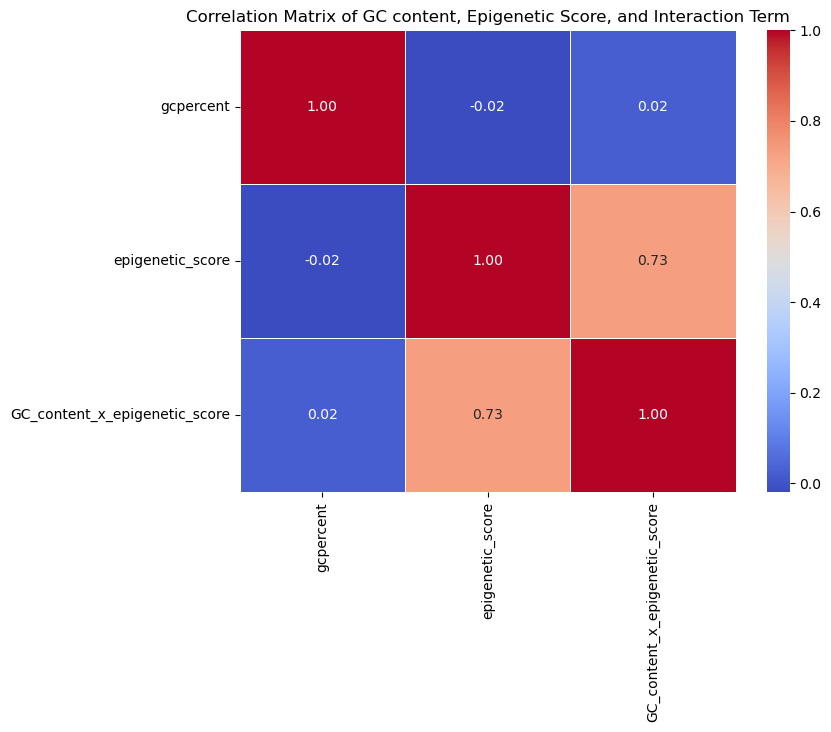

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = cleaned_data

# Step 1: Correlation Analysis
# Select the relevant columns for correlation analysis
features = data[['gcpercent', 'epigenetic_score', 'GC_content_x_epigenetic_score']]

# Calculate the correlation matrix
correlation_matrix = features.corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of GC content, Epigenetic Score, and Interaction Term")
plt.show()


/var/folders/td/t9wdd_hj7k90ttfq2_cxf4bc0000gn/T/ipykernel_17039/1060821909.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['cluster'] = dbscan.fit_predict(scaled_features)


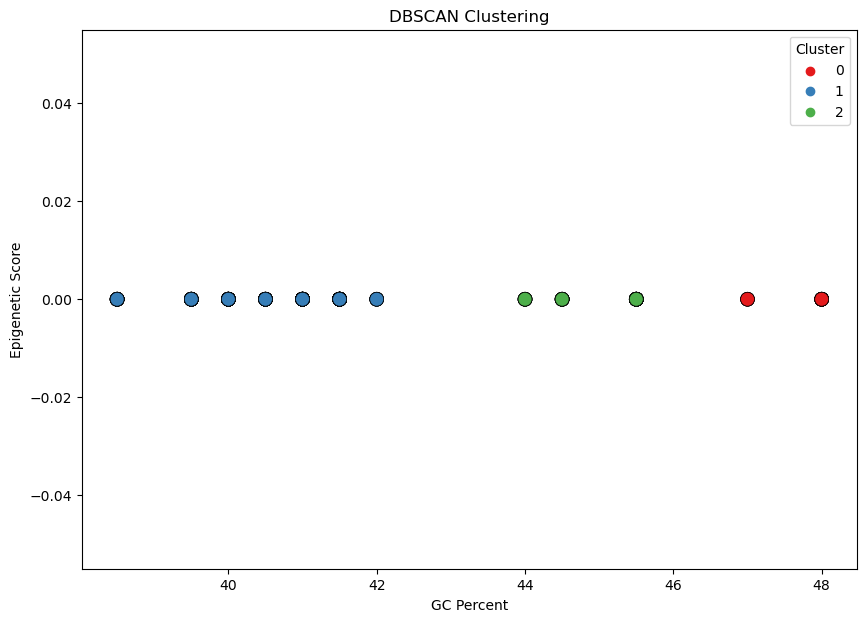

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns


# Feature selection
features = ['gcpercent', 'epigenetic_score', 'GC_content_x_epigenetic_score']

# Select a sample if the dataset is large to reduce processing time
# Subset the data (e.g., first 200 rows)
data_subset = data.head(200)

# Standardize the features (important for regression and clustering)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_subset[features])

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
data_subset['cluster'] = dbscan.fit_predict(scaled_features)

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=data_subset['gcpercent'], y=data_subset['epigenetic_score'], 
                hue=data_subset['cluster'], palette='Set1', 
                marker='o', s=100, edgecolor='black', linewidth=0.5)

plt.title('DBSCAN Clustering')
plt.xlabel('GC Percent')
plt.ylabel('Epigenetic Score')
plt.legend(title='Cluster', loc='upper right')
plt.show()


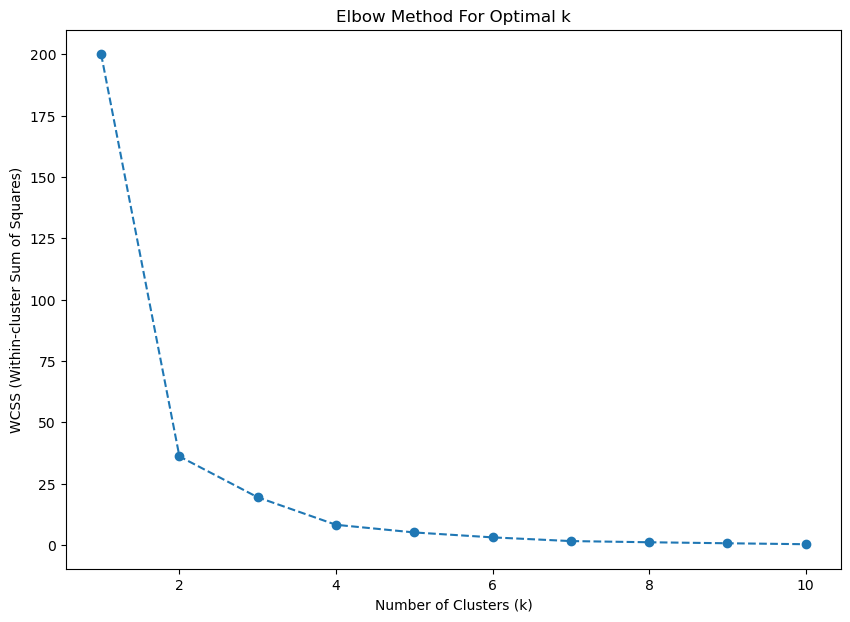

/var/folders/td/t9wdd_hj7k90ttfq2_cxf4bc0000gn/T/ipykernel_17039/2849149124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['cluster'] = kmeans.fit_predict(scaled_features)


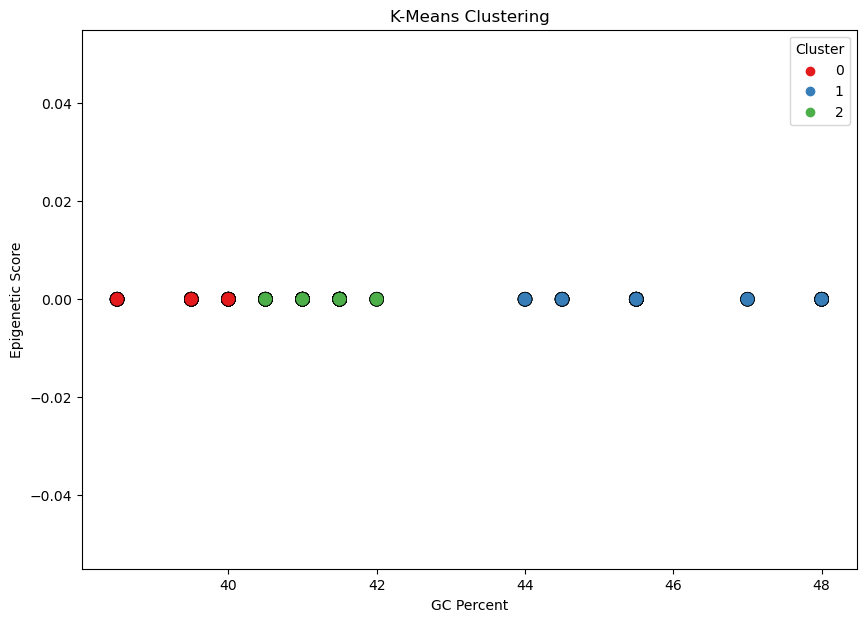

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

# Feature selection
features = ['gcpercent', 'epigenetic_score', 'GC_content_x_epigenetic_score']

# Select a sample if the dataset is large to reduce processing time
# Subset the data (e.g., first 200 rows)
data_subset = data.head(200)

# Standardize the features (important for clustering)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_subset[features])

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):  # Trying values of k from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method to choose the number of clusters
plt.figure(figsize=(10, 7))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')
plt.show()

# From the elbow plot, choose the value of k (for example, let's say k=3)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
data_subset['cluster'] = kmeans.fit_predict(scaled_features)

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=data_subset['gcpercent'], y=data_subset['epigenetic_score'], 
                hue=data_subset['cluster'], palette='Set1', 
                marker='o', s=100, edgecolor='black', linewidth=0.5)

plt.title('K-Means Clustering')
plt.xlabel('GC Percent')
plt.ylabel('Epigenetic Score')
plt.legend(title='Cluster', loc='upper right')
plt.show()


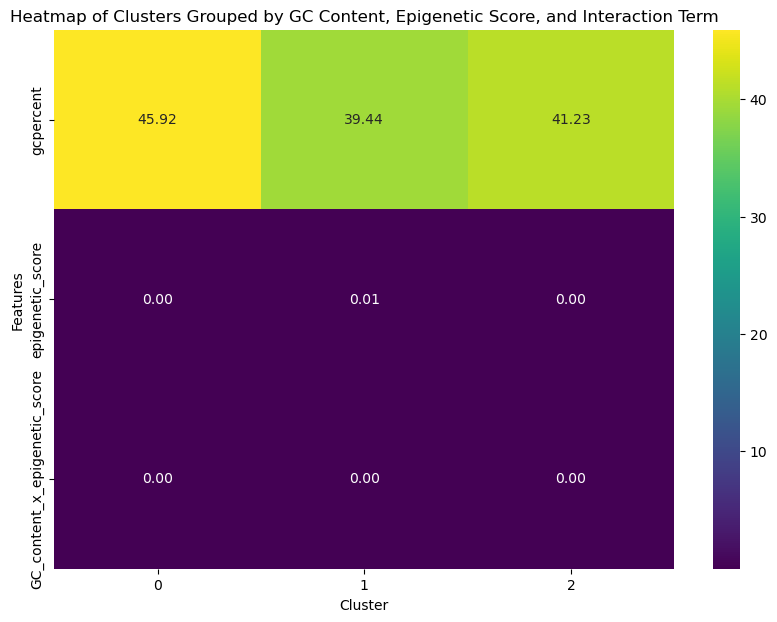

In [21]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

X = data[['gcpercent', 'epigenetic_score', 'GC_content_x_epigenetic_score']].dropna()

# Fit the KMeans model (example with 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Assign the cluster labels back to the original data
data['cluster'] = kmeans.predict(X)

# Select relevant columns for the heatmap (modify column names based on available data)
heatmap_data = data[['gcpercent', 'epigenetic_score', 'GC_content_x_epigenetic_score', 'cluster']]

# Pivot the data to get the mean values for each cluster across the features
heatmap_pivot = heatmap_data.groupby(['cluster']).mean().T

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_pivot, annot=True, cmap='viridis', fmt='.2f')
plt.title('Heatmap of Clusters Grouped by GC Content, Epigenetic Score, and Interaction Term')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.show()


/Users/himabindhudoddi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


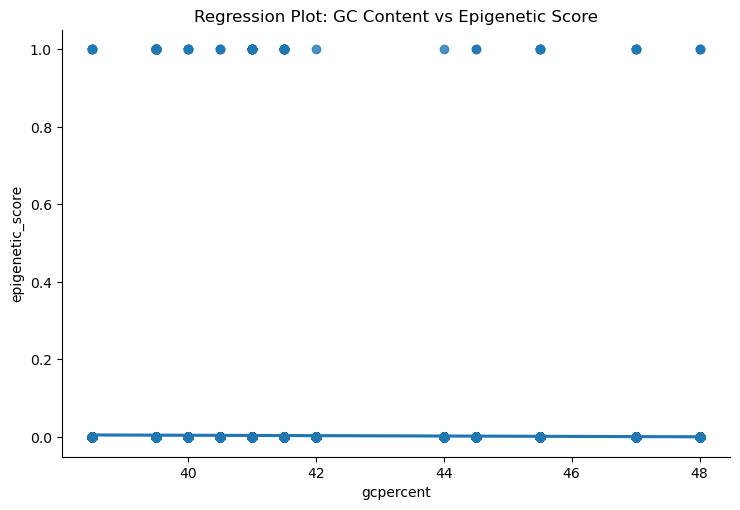

/Users/himabindhudoddi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


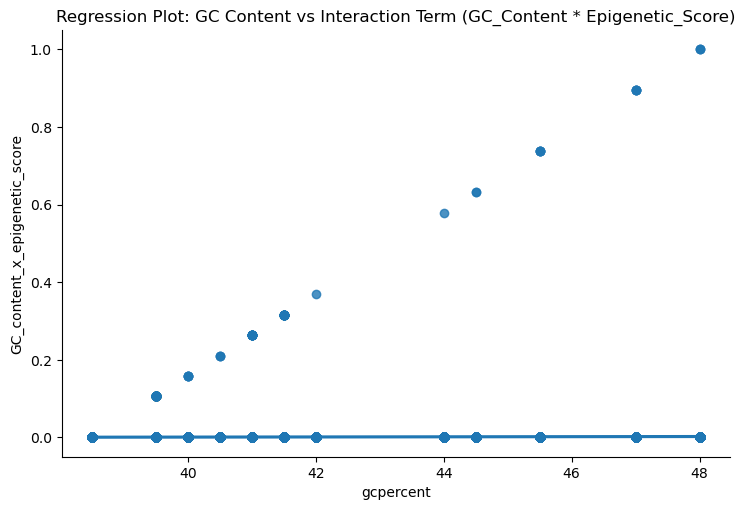

/Users/himabindhudoddi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


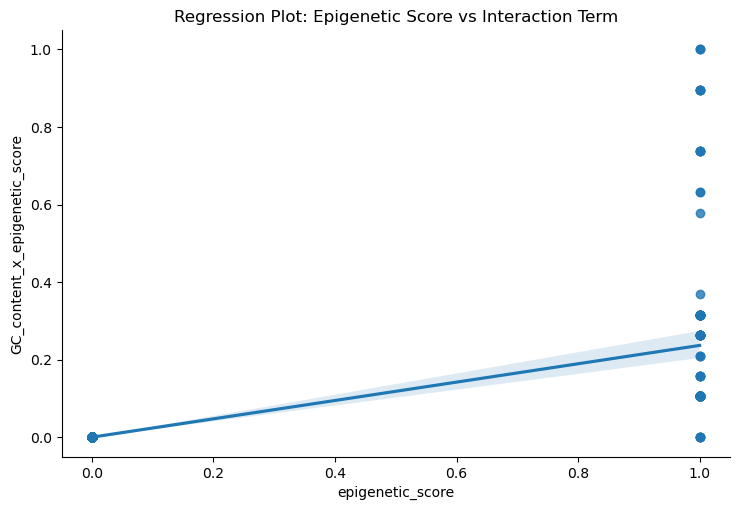

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot for GC content vs Epigenetic Score
sns.lmplot(x='gcpercent', y='epigenetic_score', data=data, aspect=1.5, logistic=False)
plt.title('Regression Plot: GC Content vs Epigenetic Score')
plt.show()

# Scatter plot for GC content vs Interaction term (if needed)
sns.lmplot(x='gcpercent', y='GC_content_x_epigenetic_score', data=data, aspect=1.5, logistic=False)
plt.title('Regression Plot: GC Content vs Interaction Term (GC_Content * Epigenetic_Score)')
plt.show()

# Scatter plot for Epigenetic Score vs Interaction term (if needed)
sns.lmplot(x='epigenetic_score', y='GC_content_x_epigenetic_score', data=data, aspect=1.5, logistic=False)
plt.title('Regression Plot: Epigenetic Score vs Interaction Term')
plt.show()
